In [199]:
import tweepy       # python wrapper for twitter api
import json
import time
import requests
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
# step 0, get your own twitter credentials!

In [200]:
# this is my own personal twitter api information
# if you could be so kind as to sign up yourself on both twitter and mashape that'd be great :)
# It's FREEEEEEE
#api_key = 'g5uPIpw80nULQI1gfklv2zrh4'
#api_secret = 'cOWvNWxYvPmEZ0ArZVeeVVvJu41QYHdUS2GpqIKtSQ1isd5PJy'
#access_token = '49722956-TWl8J0aAS6KTdcbz3ppZ7NfqZEmrwmbsb9cYPNELG'
#access_secret = '3eqrVssF3ppv23qyflyAto8wLEiYRA8sXEPSghuOJWTub'

api_key = '4VNCqvEKCVLoPpIt6pohJy0cH'
api_secret = 'tVBx6Z6MtjiktxMBV6Bv7d2JzrZxisWg8y2zXvhnKsxmznsOgl'
access_token = '220228799-pliCnKJDQY8t3rhGBwT3lAIYUXA7RX9b9NsKC24n'
access_secret = 'U61f8qmp00lTCdCJqrJ0NDbWMgwPX3FghZbsMYH1SEfZy'

In [201]:
# Documentation is your friend! http://docs.tweepy.org/en/v3.1.0/
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth) # returns a tweepy authorization handler object

In [202]:
# 1. Use Twitter API to stream and store tweets (300 per candidate)
# explain geocode is doing
bernie_tweets =  api.search(q="#berniesanders", count=500, geocode="37.781157,-122.398720,50mi") + api.search(q='#bernie', count=500, geocode="37.781157,-122.398720,50mi") + api.search(q='#FeelTheBern', count=500, geocode="37.781157,-122.398720,50mi")

hilary_tweets = api.search(q='#ImWithHer', count=500, geocode="37.781157,-122.398720,50mi") + api.search(q='#hillaryclinton', count=500, geocode="37.781157,-122.398720,50mi") + api.search(q='#hillary2016', count=500, geocode="37.781157,-122.398720,50mi")

the_donald_tweets = api.search(q='#donaldtrump', count=375, geocode="37.781157,-122.398720,50mi") + api.search(q='#trump2016', count=375, geocode="37.781157,-122.398720,50mi") + api.search(q='#trump', count=375, geocode="37.781157,-122.398720,50mi") + api.search(q='#makeamericagreatagain', count=375, geocode="37.781157,-122.398720,50mi")

# geocode is specifying that it should search within 50 miles of that latitude and longitude.

In [203]:
the_donald_tweets[0]

Status(contributors=None, truncated=False, text=u"RT @JacloPac: Thanks to #DonaldTrump there's an ignorant bush growing in America &amp; he feeds it Hate &amp; Fear. https://t.co/gr3GPrKHYI", is_quote_status=False, in_reply_to_status_id=None, id=730566798504951808L, favorite_count=0, _api=<tweepy.api.API object at 0x000000000D899940>, author=User(follow_request_sent=False, has_extended_profile=True, profile_use_background_image=True, _json={u'follow_request_sent': False, u'has_extended_profile': True, u'profile_use_background_image': True, u'default_profile_image': False, u'id': 120877403, u'profile_background_image_url_https': u'https://pbs.twimg.com/profile_background_images/252455952/x2d632c3b4324fd142fa95d69e6f29c5.jpg', u'verified': False, u'profile_text_color': u'1C1F23', u'profile_image_url_https': u'https://pbs.twimg.com/profile_images/723252097622282242/PNU3arPA_normal.jpg', u'profile_sidebar_fill_color': u'C9C9C9', u'entities': {u'description': {u'urls': []}}, u'followers_cou

In [204]:
# wrappers come with built in python attributes and methods!
print dir(the_donald_tweets[0])

['__class__', '__delattr__', '__dict__', '__doc__', '__eq__', '__format__', '__getattribute__', '__getstate__', '__hash__', '__init__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'metadata', 'parse', 'parse_list', 'place', 'possibly_sensitive', 'retweet', 'retweet_count', 'retweeted', 'retweeted_status', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


In [205]:
print the_donald_tweets[0].created_at
print the_donald_tweets[0].text
print the_donald_tweets[0].favorite_count
print the_donald_tweets[0].favorited
print the_donald_tweets[0].lang
print the_donald_tweets[0].geo
print the_donald_tweets[0].retweet_count
print the_donald_tweets[0].retweeted
print the_donald_tweets[0].possibly_sensitive
print the_donald_tweets[0].coordinates

2016-05-12 01:14:32
RT @JacloPac: Thanks to #DonaldTrump there's an ignorant bush growing in America &amp; he feeds it Hate &amp; Fear. https://t.co/gr3GPrKHYI
0
False
en
None
154
False
False
None


In [206]:
def parse_status_objects(tweet_list):
    modified_tweets = list()
    for x in tweet_list:
        modified_tweets.append( [
                    x.created_at,
                    x.text,
                    x.favorite_count,
                    x.favorited,
                    x.lang,
                    x.geo,
                    x.retweet_count,
                    x.retweeted,
                    x.coordinates
                ])
    return modified_tweets
        
hilary_tweets = parse_status_objects(hilary_tweets)
the_donald_tweets = parse_status_objects(the_donald_tweets)
bernie_tweets = parse_status_objects(bernie_tweets)

In [207]:
print bernie_tweets[0]
print the_donald_tweets[0]
print hilary_tweets[0]

[datetime.datetime(2016, 5, 12, 1, 15, 31), u'#FeelTheBern #BreakEmUp #WeAreBernie #NotMeUs #BernieSanders #BernDownForWhat #TurnItAllBlue #QueerTheBern https://t.co/HXNpHbqDpZ', 0, False, u'und', None, 0, False, None]
[datetime.datetime(2016, 5, 12, 1, 14, 32), u"RT @JacloPac: Thanks to #DonaldTrump there's an ignorant bush growing in America &amp; he feeds it Hate &amp; Fear. https://t.co/gr3GPrKHYI", 0, False, u'en', None, 154, False, None]
[datetime.datetime(2016, 5, 12, 1, 14, 28), u"RT @js_edit: Could somebody let Bernie know that he's not in charge of the rules committee? Thanks! #ImWithHer", 0, False, u'en', None, 1, False, None]


In [208]:
# 2 Create a dataframe that combines all of the tweets from each candidate
# To do so, you will need to concat the data frames
# so each row is a tweet and your columns should be 
# date, text, favorite_count,favorited, language, geocode, rwtweet count, retweeted, coordinates
pd.options.display.max_colwidth = 1000
bernie_tweets_df = pd.DataFrame(bernie_tweets)
bernie_tweets_df.columns = ['date', 'text', 'favorite_count', 'favorited', 'language', 'geocode', 'retweet_count', 'retweeted', 'coordinates']
bernie_tweets_df['candidate'] = 'bernie'
bernie_tweets_df.head()

the_donald_tweets_df = pd.DataFrame(the_donald_tweets)
the_donald_tweets_df.columns = ['date', 'text', 'favorite_count', 'favorited', 'language', 'geocode', 'retweet_count', 'retweeted', 'coordinates']
the_donald_tweets_df['candidate'] = 'donald'
the_donald_tweets_df.head()

hilary_tweets_df = pd.DataFrame(hilary_tweets)
hilary_tweets_df.columns = ['date', 'text', 'favorite_count', 'favorited', 'language', 'geocode', 'retweet_count', 'retweeted', 'coordinates']
hilary_tweets_df['candidate'] = 'hillary'
hilary_tweets_df.head()

frames = [bernie_tweets_df, the_donald_tweets_df, hilary_tweets_df]
pres_twitter = pd.concat(frames, ignore_index = True)
pres_twitter

#pres_twitter0 = bernie_tweets_df.append(hilary_tweets)

bernie_tweets_df['text'][0]
hilary_tweets_df['text'][0]
pres_twitter['text'][0]
len(pres_twitter)
len(bernie_tweets_df[bernie_tweets_df['retweet_count'] == 0]) # 107
len(the_donald_tweets_df[the_donald_tweets_df['retweet_count'] == 0]) # 70
len(hilary_tweets_df[hilary_tweets_df['retweet_count'] == 0]) # 60

pres_twitter_new = pres_twitter#.drop_duplicates() #pres_twitter[pres_twitter['retweet_count'] == 0]
len(pres_twitter_new)
pres_twitter['retweeted'].value_counts()
pres_twitter_new.head(10)


,date,text,favorite_count,favorited,language,geocode,retweet_count,retweeted,coordinates,candidate
0,2016-05-12 01:15:31,#FeelTheBern #BreakEmUp #WeAreBernie #NotMeUs #BernieSanders #BernDownForWhat #TurnItAllBlue #QueerTheBern https://t.co/HXNpHbqDpZ,0,False,und,None,0,False,None,bernie
1,2016-05-12 01:09:52,RT @AnthonyDPR: Time to vote! \n#feelthebern #election2016 #berniesanders https://t.co/aczh26KOR1,0,False,en,None,1,False,None,bernie
2,2016-05-12 01:09:51,Time to vote! \n#feelthebern #election2016 #berniesanders https://t.co/aczh26KOR1,0,False,en,None,1,False,None,bernie
3,2016-05-12 01:05:16,#Bernie2016 #BernieSanders #BernieSandersForPresident2016 #FeelTheBern #bernie #CA #PR #MT #NJ #NM #KY https://t.co/LH15qLzhUZ,0,False,und,None,0,False,None,bernie
4,2016-05-12 00:54:29,"""do not moan to me about @HillaryClinton's problems!"" says @BernieSanders while moaning about #BernieSanders problems.",1,False,en,None,0,False,None,bernie
5,2016-05-12 00:48:37,"Yay! THE List of 358 Pres. #Obama Accomplishments so far, https://t.co/6w7dZBkHw7 \n#HillaryClinton #DonaldTrump #BernieSanders\n#CNN #FoxNews",1,False,en,None,0,False,None,bernie
6,2016-05-12 00:20:44,#BernieSanders #Election2016 https://t.co/Wauk1SXvN2,0,False,und,None,0,False,None,bernie
7,2016-05-12 00:01:55,For anyone wanting to know when and where the next rally is happening! #KeepingTrack #GoBernie! #BernieSanders... https://t.co/PxWkthjvu4,0,False,en,None,0,False,None,bernie
8,2016-05-11 22:37:15,#Election2016 #HillaryClinton #BernieSanders https://t.co/2bAERw9WUB,0,False,und,None,0,False,None,bernie
9,2016-05-11 22:27:32,Come on! Switch to Democrat or undeclared if you wanna vote Bernie! #BernieSanders #BayArea #Election2016 #Vote!... https://t.co/jB7RRHVMJi,0,False,en,None,0,False,None,bernie


In [209]:
len(bernie_tweets_df[bernie_tweets_df['retweet_count'] == 0]) # 105
len(the_donald_tweets_df[the_donald_tweets_df['retweet_count'] == 0]) # 60
len(hilary_tweets_df[hilary_tweets_df['retweet_count'] == 0]) # 64
len(pres_twitter_new) # 758

1000

In [210]:
# 3 Create a function to take in a string and output the textblob sentiment of that string
def sentiment_fn(input_string):
    return TextBlob(input_string).sentiment.polarity

TextBlob(bernie_tweets_df['text'][0]).sentiment.polarity

0.0

In [211]:
# 4 Add a column to your data frame called 'sentiment' which holds the sentiment of that tweet (hint: use the function from #3)
pres_twitter_new['sentiment'] = pres_twitter_new['text'].apply(sentiment_fn)
pres_twitter_new

,date,text,favorite_count,favorited,language,geocode,retweet_count,retweeted,coordinates,candidate,sentiment
0,2016-05-12 01:15:31,#FeelTheBern #BreakEmUp #WeAreBernie #NotMeUs #BernieSanders #BernDownForWhat #TurnItAllBlue #QueerTheBern https://t.co/HXNpHbqDpZ,0,False,und,None,0,False,None,bernie,0.000000e+00
1,2016-05-12 01:09:52,RT @AnthonyDPR: Time to vote! \n#feelthebern #election2016 #berniesanders https://t.co/aczh26KOR1,0,False,en,None,1,False,None,bernie,0.000000e+00
2,2016-05-12 01:09:51,Time to vote! \n#feelthebern #election2016 #berniesanders https://t.co/aczh26KOR1,0,False,en,None,1,False,None,bernie,0.000000e+00
3,2016-05-12 01:05:16,#Bernie2016 #BernieSanders #BernieSandersForPresident2016 #FeelTheBern #bernie #CA #PR #MT #NJ #NM #KY https://t.co/LH15qLzhUZ,0,False,und,None,0,False,None,bernie,0.000000e+00
4,2016-05-12 00:54:29,"""do not moan to me about @HillaryClinton's problems!"" says @BernieSanders while moaning about #BernieSanders problems.",1,False,en,None,0,False,None,bernie,0.000000e+00
5,2016-05-12 00:48:37,"Yay! THE List of 358 Pres. #Obama Accomplishments so far, https://t.co/6w7dZBkHw7 \n#HillaryClinton #DonaldTrump #BernieSanders\n#CNN #FoxNews",1,False,en,None,0,False,None,bernie,1.000000e-01
6,2016-05-12 00:20:44,#BernieSanders #Election2016 https://t.co/Wauk1SXvN2,0,False,und,None,0,False,None,bernie,0.000000e+00
7,2016-05-12 00:01:55,For anyone wanting to know when and where the next rally is happening! #KeepingTrack #GoBernie! #BernieSanders... https://t.co/PxWkthjvu4,0,False,en,None,0,False,None,bernie,0.000000e+00
8,2016-05-11 22:37:15,#Election2016 #HillaryClinton #BernieSanders https://t.co/2bAERw9WUB,0,False,und,None,0,False,None,bernie,0.000000e+00
9,2016-05-11 22:27:32,Come on! Switch to Democrat or undeclared if you wanna vote Bernie! #BernieSanders #BayArea #Election2016 #Vote!... https://t.co/jB7RRHVMJi,0,False,en,None,0,False,None,bernie,0.000000e+00


In [212]:
# 5 create a word count column, which holds the number of words in the text column
def get_word_count(a):
    return len(a.split())

pres_twitter_new['word_count'] = pres_twitter_new['text'].apply(get_word_count)
pres_twitter_new['word_count']
pres_twitter_new

,date,text,favorite_count,favorited,language,geocode,retweet_count,retweeted,coordinates,candidate,sentiment,word_count
0,2016-05-12 01:15:31,#FeelTheBern #BreakEmUp #WeAreBernie #NotMeUs #BernieSanders #BernDownForWhat #TurnItAllBlue #QueerTheBern https://t.co/HXNpHbqDpZ,0,False,und,None,0,False,None,bernie,0.000000e+00,9
1,2016-05-12 01:09:52,RT @AnthonyDPR: Time to vote! \n#feelthebern #election2016 #berniesanders https://t.co/aczh26KOR1,0,False,en,None,1,False,None,bernie,0.000000e+00,9
2,2016-05-12 01:09:51,Time to vote! \n#feelthebern #election2016 #berniesanders https://t.co/aczh26KOR1,0,False,en,None,1,False,None,bernie,0.000000e+00,7
3,2016-05-12 01:05:16,#Bernie2016 #BernieSanders #BernieSandersForPresident2016 #FeelTheBern #bernie #CA #PR #MT #NJ #NM #KY https://t.co/LH15qLzhUZ,0,False,und,None,0,False,None,bernie,0.000000e+00,12
4,2016-05-12 00:54:29,"""do not moan to me about @HillaryClinton's problems!"" says @BernieSanders while moaning about #BernieSanders problems.",1,False,en,None,0,False,None,bernie,0.000000e+00,15
5,2016-05-12 00:48:37,"Yay! THE List of 358 Pres. #Obama Accomplishments so far, https://t.co/6w7dZBkHw7 \n#HillaryClinton #DonaldTrump #BernieSanders\n#CNN #FoxNews",1,False,en,None,0,False,None,bernie,1.000000e-01,16
6,2016-05-12 00:20:44,#BernieSanders #Election2016 https://t.co/Wauk1SXvN2,0,False,und,None,0,False,None,bernie,0.000000e+00,3
7,2016-05-12 00:01:55,For anyone wanting to know when and where the next rally is happening! #KeepingTrack #GoBernie! #BernieSanders... https://t.co/PxWkthjvu4,0,False,en,None,0,False,None,bernie,0.000000e+00,17
8,2016-05-11 22:37:15,#Election2016 #HillaryClinton #BernieSanders https://t.co/2bAERw9WUB,0,False,und,None,0,False,None,bernie,0.000000e+00,4
9,2016-05-11 22:27:32,Come on! Switch to Democrat or undeclared if you wanna vote Bernie! #BernieSanders #BayArea #Election2016 #Vote!... https://t.co/jB7RRHVMJi,0,False,en,None,0,False,None,bernie,0.000000e+00,17


In [213]:
# use countvectorizer to create a document-term matrix and concatinate it to your main dataframe
#(hint you should now have thousands of columns)
vect = CountVectorizer(stop_words='english')#, max_features=10)
doc_matrix = vect.fit_transform(pres_twitter_new['text'])
doc_matrix
doc_matrix_df = pd.DataFrame(doc_matrix.toarray())
doc_matrix_df.head()

frames1 = [pres_twitter_new, doc_matrix_df]
pres_twitter1 = pd.concat(frames1, axis=1, join_axes=[pres_twitter_new.index])
pres_twitter1

,date,text,favorite_count,favorited,language,geocode,retweet_count,retweeted,coordinates,candidate,...,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280
0,2016-05-12 01:15:31,#FeelTheBern #BreakEmUp #WeAreBernie #NotMeUs #BernieSanders #BernDownForWhat #TurnItAllBlue #QueerTheBern https://t.co/HXNpHbqDpZ,0,False,und,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,0
1,2016-05-12 01:09:52,RT @AnthonyDPR: Time to vote! \n#feelthebern #election2016 #berniesanders https://t.co/aczh26KOR1,0,False,en,None,1,False,None,bernie,...,0,0,0,0,0,0,0,0,0,0
2,2016-05-12 01:09:51,Time to vote! \n#feelthebern #election2016 #berniesanders https://t.co/aczh26KOR1,0,False,en,None,1,False,None,bernie,...,0,0,0,0,0,0,0,0,0,0
3,2016-05-12 01:05:16,#Bernie2016 #BernieSanders #BernieSandersForPresident2016 #FeelTheBern #bernie #CA #PR #MT #NJ #NM #KY https://t.co/LH15qLzhUZ,0,False,und,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,0
4,2016-05-12 00:54:29,"""do not moan to me about @HillaryClinton's problems!"" says @BernieSanders while moaning about #BernieSanders problems.",1,False,en,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,0
5,2016-05-12 00:48:37,"Yay! THE List of 358 Pres. #Obama Accomplishments so far, https://t.co/6w7dZBkHw7 \n#HillaryClinton #DonaldTrump #BernieSanders\n#CNN #FoxNews",1,False,en,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,0
6,2016-05-12 00:20:44,#BernieSanders #Election2016 https://t.co/Wauk1SXvN2,0,False,und,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,0
7,2016-05-12 00:01:55,For anyone wanting to know when and where the next rally is happening! #KeepingTrack #GoBernie! #BernieSanders... https://t.co/PxWkthjvu4,0,False,en,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,0
8,2016-05-11 22:37:15,#Election2016 #HillaryClinton #BernieSanders https://t.co/2bAERw9WUB,0,False,und,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,0
9,2016-05-11 22:27:32,Come on! Switch to Democrat or undeclared if you wanna vote Bernie! #BernieSanders #BayArea #Election2016 #Vote!... https://t.co/jB7RRHVMJi,0,False,en,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,0


In [214]:
# Prep the dataset for clustering
pres_twitter1['favorite_count'].value_counts()
pres_twitter1['favorited'].value_counts()
pres_twitter1['retweet_count'].value_counts()
pres_twitter1['retweeted'].value_counts()
pres_twitter1

pres_twitter2 = pres_twitter1.drop('favorited', axis=1)
pres_twitter2.pop('language')
pres_twitter2.pop('date')
pres_twitter2.pop('text')
pres_twitter2.pop('geocode')
pres_twitter2.pop('retweeted')
pres_twitter2.pop('coordinates')
pres_twitter2.pop('candidate')
pres_twitter2
X = pres_twitter2
np.any(np.isnan(X))
#X['word_count'].isnull().sum()
X.head()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.29859869, -0.39912212, -0.12751282, ..., -0.0316386 ,
        -0.0316386 , -0.0316386 ],
       [-0.29859869, -0.38737459, -0.12751282, ..., -0.0316386 ,
        -0.0316386 , -0.0316386 ],
       [-0.29859869, -0.38737459, -0.12751282, ..., -0.0316386 ,
        -0.0316386 , -0.0316386 ],
       ..., 
       [-0.29859869,  5.33366943,  0.22250586, ..., -0.0316386 ,
        -0.0316386 , -0.0316386 ],
       [-0.29859869,  5.33366943,  0.22250586, ..., -0.0316386 ,
        -0.0316386 , -0.0316386 ],
       [-0.29859869,  5.12221401, -0.12751282, ..., -0.0316386 ,
        -0.0316386 , -0.0316386 ]])

In [215]:
# 6 Use kmean to create clusters for the dataframe
km = KMeans(n_clusters=3)
km.fit(X_scaled)
km.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

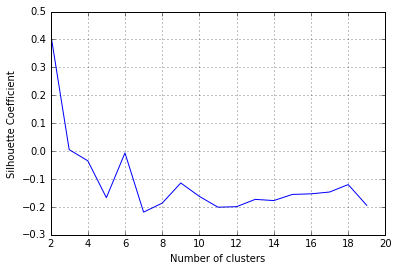

In [216]:
k_range = range(2, 20)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [217]:
km = KMeans(n_clusters=2)
km.fit(X_scaled)
pres_twitter2['clusters'] = km.labels_
pres_twitter1['clusters'] = km.labels_
pres_twitter1.head(10)

,date,text,favorite_count,favorited,language,geocode,retweet_count,retweeted,coordinates,candidate,...,2272,2273,2274,2275,2276,2277,2278,2279,2280,clusters
0,2016-05-12 01:15:31,#FeelTheBern #BreakEmUp #WeAreBernie #NotMeUs #BernieSanders #BernDownForWhat #TurnItAllBlue #QueerTheBern https://t.co/HXNpHbqDpZ,0,False,und,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,1
1,2016-05-12 01:09:52,RT @AnthonyDPR: Time to vote! \n#feelthebern #election2016 #berniesanders https://t.co/aczh26KOR1,0,False,en,None,1,False,None,bernie,...,0,0,0,0,0,0,0,0,0,1
2,2016-05-12 01:09:51,Time to vote! \n#feelthebern #election2016 #berniesanders https://t.co/aczh26KOR1,0,False,en,None,1,False,None,bernie,...,0,0,0,0,0,0,0,0,0,1
3,2016-05-12 01:05:16,#Bernie2016 #BernieSanders #BernieSandersForPresident2016 #FeelTheBern #bernie #CA #PR #MT #NJ #NM #KY https://t.co/LH15qLzhUZ,0,False,und,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,1
4,2016-05-12 00:54:29,"""do not moan to me about @HillaryClinton's problems!"" says @BernieSanders while moaning about #BernieSanders problems.",1,False,en,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,1
5,2016-05-12 00:48:37,"Yay! THE List of 358 Pres. #Obama Accomplishments so far, https://t.co/6w7dZBkHw7 \n#HillaryClinton #DonaldTrump #BernieSanders\n#CNN #FoxNews",1,False,en,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,1
6,2016-05-12 00:20:44,#BernieSanders #Election2016 https://t.co/Wauk1SXvN2,0,False,und,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,1
7,2016-05-12 00:01:55,For anyone wanting to know when and where the next rally is happening! #KeepingTrack #GoBernie! #BernieSanders... https://t.co/PxWkthjvu4,0,False,en,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,1
8,2016-05-11 22:37:15,#Election2016 #HillaryClinton #BernieSanders https://t.co/2bAERw9WUB,0,False,und,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,1
9,2016-05-11 22:27:32,Come on! Switch to Democrat or undeclared if you wanna vote Bernie! #BernieSanders #BayArea #Election2016 #Vote!... https://t.co/jB7RRHVMJi,0,False,en,None,0,False,None,bernie,...,0,0,0,0,0,0,0,0,0,1


In [221]:
# 7 Explore the clusters
# What is interesting? Surprising? Can you draw any inferences about each cluster?
# Write your answer to these questions in markdown
# Please see hw2.md
pd.options.display.max_colwidth = 2000
#pres_twitter1.groupby('clusters').mean()
# pres_twitter1['clusters'].value_counts()
#pres_twitter2[pres_twitter2['clusters'] == 1]
#pres_twitter1[pres_twitter1['clusters'] == 1]['text']
#df1 = pres_twitter2[pres_twitter2['clusters'] == 1].transpose()
#df1
#df1.columns = ['obs1']
#df1[df1['obs1'] > 0]
#pres_twitter1.groupby('clusters').mean()
#len(pres_twitter1[pres_twitter1['retweet_count'] > 0]) # 536
#len(pres_twitter1) # 758
pres_twitter1['clusters'].value_counts()


1    992
0      8
Name: clusters, dtype: int64

In [222]:
pres_twitter2.head()

,favorite_count,retweet_count,sentiment,word_count,0,1,2,3,4,5,...,2272,2273,2274,2275,2276,2277,2278,2279,2280,clusters
0,0,0,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [223]:
pres_twitter1[pres_twitter1['clusters'] == 0]['text']

529      RT @Corporatocrazy: Obamacare spent $2.4 BILLION creating 23 Co-Ops\n12 of those have FAILED\n11 lost $400 million last yr, looking for state…
535      RT @Corporatocrazy: Obamacare spent $2.4 BILLION creating 23 Co-Ops\n12 of those have FAILED\n11 lost $400 million last yr, looking for state…
544      RT @Corporatocrazy: Obamacare spent $2.4 BILLION creating 23 Co-Ops\n12 of those have FAILED\n11 lost $400 million last yr, looking for state…
548      RT @Corporatocrazy: Obamacare spent $2.4 BILLION creating 23 Co-Ops\n12 of those have FAILED\n11 lost $400 million last yr, looking for state…
550      RT @Corporatocrazy: Obamacare spent $2.4 BILLION creating 23 Co-Ops\n12 of those have FAILED\n11 lost $400 million last yr, looking for state…
552      RT @Corporatocrazy: Obamacare spent $2.4 BILLION creating 23 Co-Ops\n12 of those have FAILED\n11 lost $400 million last yr, looking for state…
571      RT @Corporatocrazy: Obamacare spent $2.4 BILLION creating 23 Co-Ops\n12 of thos

In [224]:
# 8 Create a column called 'democrat' and assign it to the corresponding candidate name for all the records
# 1 for bernie and hilary and 0 for donald trump
def dem_ind(a):
    if a == 'bernie' or a == 'hillary':
        democrat_ind = 1
    else:
        democrat_ind = 0
    return democrat_ind

pres_twitter1['democrat'] = pres_twitter1['candidate'].apply(dem_ind)
pres_twitter1.head()
pres_twitter1.democrat.value_counts()

1    600
0    400
Name: democrat, dtype: int64

In [225]:
# 9 Estimate classification models using knn and logistic regession.  Dont forget to use cross validation 
    # (do not use cross_val_score because we will want a confusion matrix).
# Use a three class response variable for knn.  For logistic regression predict democrat or republic?
#Assess the pros and cons of both approaches
#Extra Credit: Estimate multinomial regression model using the three class response variable
y_knn = pres_twitter1['candidate']
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y_knn, random_state=1)
len(X_train_knn)
len(X_test_knn)

y_log = pres_twitter1['democrat']
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, random_state=1)
len(X_train_log)
len(X_test_log)

250

In [226]:
# 10 Initialize a classification model (for both knn and logistic)
knn = KNeighborsClassifier(n_neighbors=3)

logreg = LogisticRegression(C=1e9)

In [227]:
# 11 Train your classification model  (for both knn and logistic)
knn.fit(X_train_knn, y_train_knn)

logreg.fit(X_train_log, y_train_log)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [228]:
# 12 Predict on your test features and targets (for both knn and logistic)
knn_pred = knn.predict(X_test_knn)
knn_pred

logistic_pred = logreg.predict(X_test_log)
logistic_pred
print metrics.confusion_matrix(y_test_log, logistic_pred)

[[101   4]
 [  3 142]]


In [229]:
# 13 output your accuracy (for both knn and logistic)
print knn.score(X_test_knn, y_test_knn)

accuracy_log = (101+142)/float(250)
accuracy_log

0.804


0.972

In [231]:
# 14 Create a confusion matrix for your predictions (for both knn and logistic)
print metrics.confusion_matrix(y_test_knn, knn_pred)
print Counter(knn_pred)

print metrics.confusion_matrix(y_test_log, logistic_pred)
print Counter(logistic_pred)

[[57  6  9]
 [11 86  8]
 [13  2 58]]
Counter({'donald': 94, 'bernie': 81, 'hillary': 75})
[[101   4]
 [  3 142]]
Counter({1: 146, 0: 104})


In [213]:
# 15 Who is the easiest candidate to predict? Why do you think? Who is the hardest? Why do you think?
# Write your answers in markdown (for both knn and logistic)
# Please see hw2.md

In [214]:
# 16 What are some extra features (data points) you would like to add to this data set. Explain in markdown.
# (hint maybe something like a boolean, "has_hashtag")
# Please see hw2.md

In [232]:
# 17 Try adding extra features to improve the quality of your predictions (for both knn and logistic)
def at_symbol_fn(b):
    if b.find("@") >  0:
        return 1
    else:
        return 0

pres_twitter1['at_symbol'] = pres_twitter['text'].apply(at_symbol_fn)
pres_twitter1['at_symbol'].value_counts()

def website_fn(b):
    if b.find("//") >  0:
        return 1
    else:
        return 0

pres_twitter1['website'] = pres_twitter['text'].apply(website_fn)
pres_twitter1['website'].value_counts()

1    767
0    233
Name: website, dtype: int64

In [233]:
pres_twitter1['favorite_count'].value_counts()
pres_twitter1['favorited'].value_counts()
pres_twitter1['retweet_count'].value_counts()
pres_twitter1['retweeted'].value_counts()
pres_twitter1

pres_twitter2 = pres_twitter1.drop('favorited', axis=1)
pres_twitter2.pop('language')
pres_twitter2.pop('date')
pres_twitter2.pop('text')
pres_twitter2.pop('geocode')
pres_twitter2.pop('retweeted')
pres_twitter2.pop('coordinates')
pres_twitter2.pop('candidate')
pres_twitter2
X = pres_twitter2
np.any(np.isnan(X))
X.head()

,favorite_count,retweet_count,sentiment,word_count,0,1,2,3,4,5,...,2275,2276,2277,2278,2279,2280,clusters,democrat,at_symbol,website
0,0,0,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
1,0,1,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
2,0,1,0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
3,0,0,0,12,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
4,1,0,0,15,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0


In [234]:
y_knn = pres_twitter1['candidate']
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y_knn, random_state=1)
len(X_train_knn)
len(X_test_knn)

y_log = pres_twitter1['democrat']
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, random_state=1)
len(X_train_log)
len(X_test_log)

250

In [235]:
knn = KNeighborsClassifier(n_neighbors=3)

logreg = LogisticRegression(C=1e9)

In [236]:
knn.fit(X_train_knn, y_train_knn)

logreg.fit(X_train_log, y_train_log)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [237]:
knn_pred = knn.predict(X_test_knn)
knn_pred

logistic_pred = logreg.predict(X_test_log)
logistic_pred
print metrics.confusion_matrix(y_test_log, logistic_pred)

[[105   0]
 [  0 145]]


In [238]:
print knn.score(X_test_knn, y_test_knn)

accuracy_log = (72+117)/float(190)
accuracy_log

0.848


0.9947368421052631

In [239]:
print metrics.confusion_matrix(y_test_knn, knn_pred)
print Counter(logistic_pred)

print metrics.confusion_matrix(y_test_log, logistic_pred)
print Counter(knn_pred)

[[60  2 10]
 [ 9 90  6]
 [10  1 62]]
Counter({1: 145, 0: 105})
[[105   0]
 [  0 145]]
Counter({'donald': 93, 'bernie': 79, 'hillary': 78})
